In [1]:
!pip install torch torchvision torchattacks


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [3]:
batch_size = 8

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


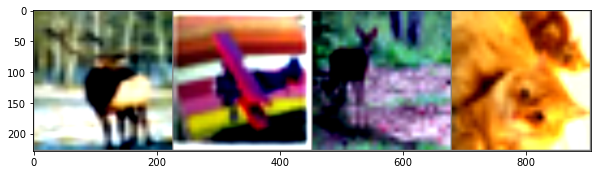

deer plane deer cat


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(10, 5))
imshow(torchvision.utils.make_grid(images[:4]))
plt.show()
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))


In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model.classifier[6] = nn.Linear(4096, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Using cache found in C:\Users\Admin/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
num_epochs = 2

subset_size = 5000
train_subset, _ = torch.utils.data.random_split(train_dataset, [subset_size, len(train_dataset) - subset_size])
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/2, Loss: 2.3370, Train Accuracy: 0.1030, Val Accuracy: 0.1000
Epoch 2/2, Loss: 2.3104, Train Accuracy: 0.1092, Val Accuracy: 0.1000


In [8]:
torch.save(model.state_dict(), 'vgg16_cifar10.pth')


In [9]:
model.load_state_dict(torch.load('vgg16_cifar10.pth'))
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')


Accuracy of the network on the 10000 test images: 10.00 %


In [11]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname] if total_pred[classname] > 0 else 0
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 100.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


In [12]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model.classifier[6] = nn.Linear(4096, 10)
model.load_state_dict(torch.load('vgg16_cifar10.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

attack_pifgsmp = torchattacks.PIFGSMPP(model, max_epsilon=16/255, num_iter_set=10, momentum=1.0, amplification=10.0, prob=0.7, project_factor=0.8)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_pifgsmp(images, labels)

    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


Using cache found in C:\Users\Admin/.cache\torch\hub\pytorch_vision_v0.10.0


Success Rate: 0.0000
No successful attacks to display.


In [13]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model.classifier[6] = nn.Linear(4096, 10)
model.load_state_dict(torch.load('vgg16_cifar10.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

attack_pifgsm = torchattacks.PIFGSM(model, max_epsilon=16/255, num_iter_set=10, momentum=1.0, amplification=10.0, prob=0.7)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_pifgsm(images, labels)

    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


Using cache found in C:\Users\Admin/.cache\torch\hub\pytorch_vision_v0.10.0


Success Rate: 0.0000
No successful attacks to display.
